In [ ]:
# Impor library yang akan digunakan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from windrose import WindroseAxes

# Pengaturan untuk visualisasi
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [9]:
!pip install windrose


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
## 2. Memuat Data dari File Excel

!pip install openpyxl

path_data_bersih = '825230074_DataBersih.xlsx'

try:
    df = pd.read_excel(path_data_bersih)
    print("✅ Berhasil memuat file Excel.")
except FileNotFoundError:
    print(f"Error: File tidak ditemukan di path '{path_data_bersih}'")
    raise

print("\n⬇️ Nama kolom yang terdeteksi di file Anda adalah: ⬇️")
print(df.columns.tolist())
print("--------------------------------------------------")

print("\nContoh data:")
df.head()


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


✅ Berhasil memuat file Excel.

⬇️ Nama kolom yang terdeteksi di file Anda adalah: ⬇️
['Unnamed: 0', 'TANGGAL', 'KECEPATAN_ANGIN_MAKSIMUM', 'ARAH_ANGIN_KECEPATAN_MAKSIMUM', 'KECEPATAN_ANGIN_RATA', 'ARAH_ANGIN_TERBANYAK', 'KOTA']
--------------------------------------------------

Contoh data:


,Unnamed: 0,TANGGAL,KECEPATAN_ANGIN_MAKSIMUM,ARAH_ANGIN_KECEPATAN_MAKSIMUM,KECEPATAN_ANGIN_RATA,ARAH_ANGIN_TERBANYAK,KOTA
0,0,01-01-2011,4,45,3,SW,ACEH
1,1,02-01-2011,4,135,3,E,ACEH
2,2,03-01-2011,5,135,3,E,ACEH
3,3,04-01-2011,5,135,2,E,ACEH
4,4,05-01-2011,4,90,4,E,ACEH


In [ ]:
## 3. Pra-Pemrosesan dan Konversi Angin ke Vektor

# --- PENYESUAIAN NAMA KOLOM SESUAI FILE ---
KOLOM_TANGGAL = 'TANGGAL'
KOLOM_ARAH_ANGIN = 'ARAH_ANGIN_KECEPATAN_MAKSIMUM'
KOLOM_KEC_ANGIN = 'KECEPATAN_ANGIN_RATA'
KOLOM_WILAYAH = 'KOTA'

# Memilih hanya kolom yang diperlukan dari DataFrame 'df' yang sudah dimuat
df_selected = df[[KOLOM_TANGGAL, KOLOM_ARAH_ANGIN, KOLOM_KEC_ANGIN, KOLOM_WILAYAH]].copy()

# Mengubah tipe data dan menangani error
df_selected[KOLOM_TANGGAL] = pd.to_datetime(df_selected[KOLOM_TANGGAL], format='%d-%m-%Y')
df_selected[KOLOM_ARAH_ANGIN] = pd.to_numeric(df_selected[KOLOM_ARAH_ANGIN], errors='coerce')
df_selected[KOLOM_KEC_ANGIN] = pd.to_numeric(df_selected[KOLOM_KEC_ANGIN], errors='coerce')

# Menghapus baris dengan data angin yang tidak valid
df_cleaned = df_selected.dropna()
print(f"Jumlah baris setelah dibersihkan: {len(df_cleaned)}")


# --- KONVERSI KE VEKTOR U dan V ---
# Mengubah derajat ke radian
direction_rad = np.deg2rad(df_cleaned[KOLOM_ARAH_ANGIN])
speed = df_cleaned[KOLOM_KEC_ANGIN]

# Menghitung komponen U (barat-timur) dan V (selatan-utara)
df_cleaned['U'] = -speed * np.sin(direction_rad)
df_cleaned['V'] = -speed * np.cos(direction_rad)


# --- MEMPERSIAPKAN FITUR UNTUK CLUSTERING ---
features = ['U', 'V']
X = df_cleaned[features]

# Standarisasi data -> Wajib untuk K-Means
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\n✅ Data berhasil diproses dan siap untuk clustering.")
df_cleaned.head()

Jumlah baris setelah dibersihkan: 10907

✅ Data berhasil diproses dan siap untuk clustering.


,TANGGAL,ARAH_ANGIN_KECEPATAN_MAKSIMUM,KECEPATAN_ANGIN_RATA,KOTA,U,V
0,2011-01-01,45,3,ACEH,-2.121320,-2.121320e+00
1,2011-01-02,135,3,ACEH,-2.121320,2.121320e+00
2,2011-01-03,135,3,ACEH,-2.121320,2.121320e+00
3,2011-01-04,135,2,ACEH,-1.414214,1.414214e+00
4,2011-01-05,90,4,ACEH,-4.000000,-2.449294e-16


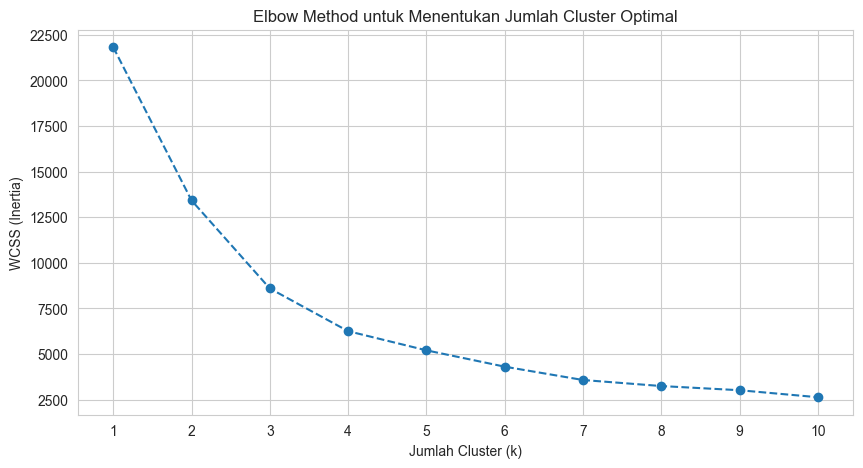

In [20]:
# Menghitung WCSS untuk berbagai jumlah cluster
wcss = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Membuat plot Elbow Method
plt.figure(figsize=(10, 5))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.title('Elbow Method untuk Menentukan Jumlah Cluster Optimal')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(k_range)
plt.show()

In [ ]:
# Tentukan jumlah cluster optimal berdasarkan plot Elbow
OPTIMAL_K = 4 

# Membuat model K-Means
kmeans_final = KMeans(n_clusters=OPTIMAL_K, init='k-means++', random_state=42, n_init=10)
kmeans_final.fit(X_scaled)

# Menambahkan hasil label cluster ke DataFrame
df_cleaned['Cluster'] = kmeans_final.labels_

# Menghitung Silhouette Score untuk evaluasi
score = silhouette_score(X_scaled, kmeans_final.labels_)
print(f"Silhouette Score untuk k={OPTIMAL_K} adalah: {score:.3f}")

print("\nData dengan Label Cluster:")
df_cleaned.head()

Silhouette Score untuk k=4 adalah: 0.413

Data dengan Label Cluster:


,TANGGAL,ARAH_ANGIN_KECEPATAN_MAKSIMUM,KECEPATAN_ANGIN_RATA,KOTA,U,V,Cluster
0,2011-01-01,45,3,ACEH,-2.121320,-2.121320e+00,2
1,2011-01-02,135,3,ACEH,-2.121320,2.121320e+00,1
2,2011-01-03,135,3,ACEH,-2.121320,2.121320e+00,1
3,2011-01-04,135,2,ACEH,-1.414214,1.414214e+00,1
4,2011-01-05,90,4,ACEH,-4.000000,-2.449294e-16,1


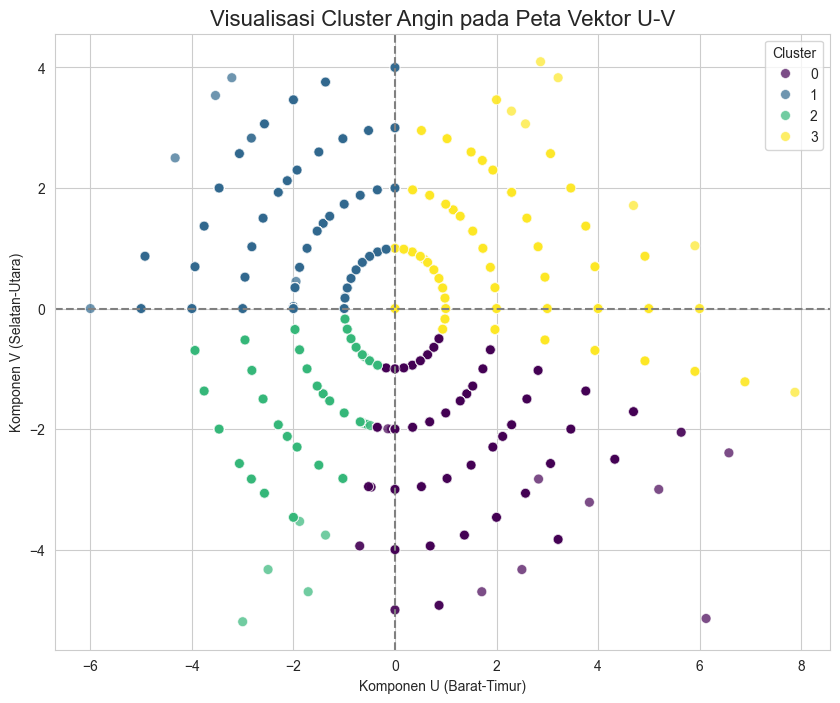

In [22]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='U', y='V', hue='Cluster', data=df_cleaned, palette='viridis', s=50, alpha=0.7)
plt.title('Visualisasi Cluster Angin pada Peta Vektor U-V', fontsize=16)
plt.xlabel('Komponen U (Barat-Timur)')
plt.ylabel('Komponen V (Selatan-Utara)')
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.legend(title='Cluster')
plt.show()

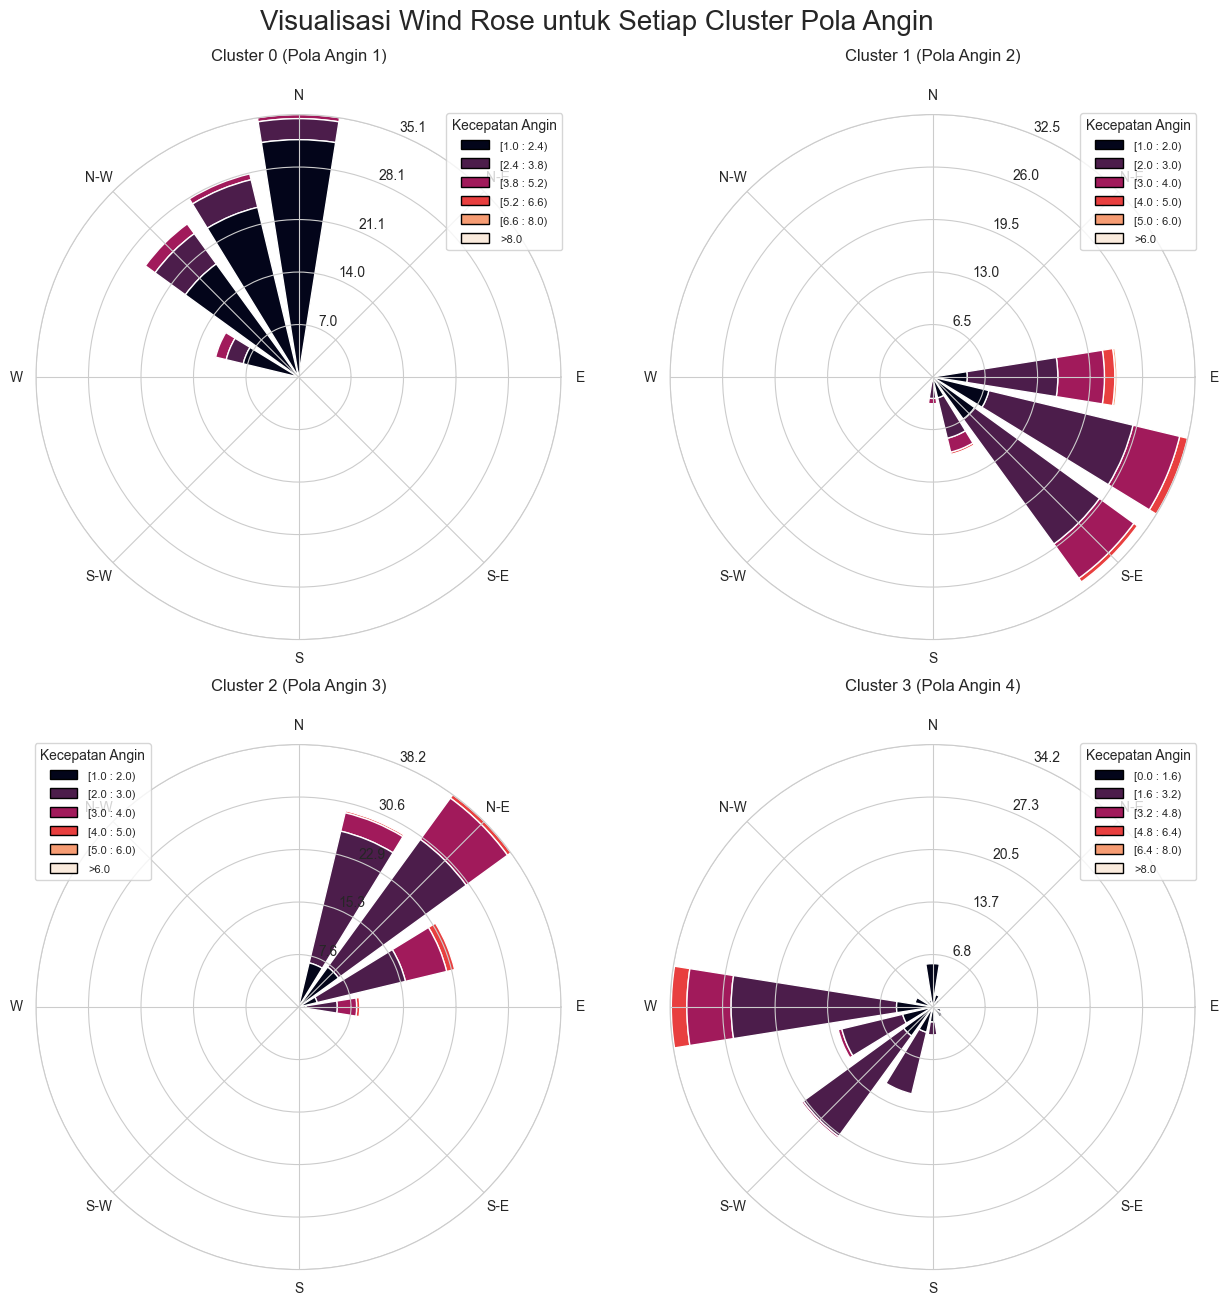

In [ ]:
## 6.2. Visualisasi Pola Angin per Cluster dengan Wind Rose

# Membuat plot Wind Rose untuk setiap cluster
fig = plt.figure(figsize=(15, 15))

for i in range(OPTIMAL_K):
    ax = fig.add_subplot(2, 2, i + 1, projection='windrose')
    
    cluster_data = df_cleaned[df_cleaned['Cluster'] == i]
    
    # Pastikan data tidak kosong sebelum membuat plot
    if not cluster_data.empty:
        ax.bar(
            cluster_data[KOLOM_ARAH_ANGIN],
            cluster_data[KOLOM_KEC_ANGIN],
            normed=True,
            opening=0.8,
            edgecolor='white'
        )
    
    ax.set_title(f'Cluster {i} (Pola Angin {i+1})', pad=20)
    ax.set_legend(title='Kecepatan Angin', loc='best')

plt.suptitle('Visualisasi Wind Rose untuk Setiap Cluster Pola Angin', fontsize=20, y=0.95)
plt.show()

Distribusi Jumlah Hari per Cluster di Setiap Wilayah:
Cluster     0     1     2    3
KOTA                          
ACEH      916   775  1253  740
JAKARTA  1029   312  1599  648
LAMPUNG   791  1791   565  488


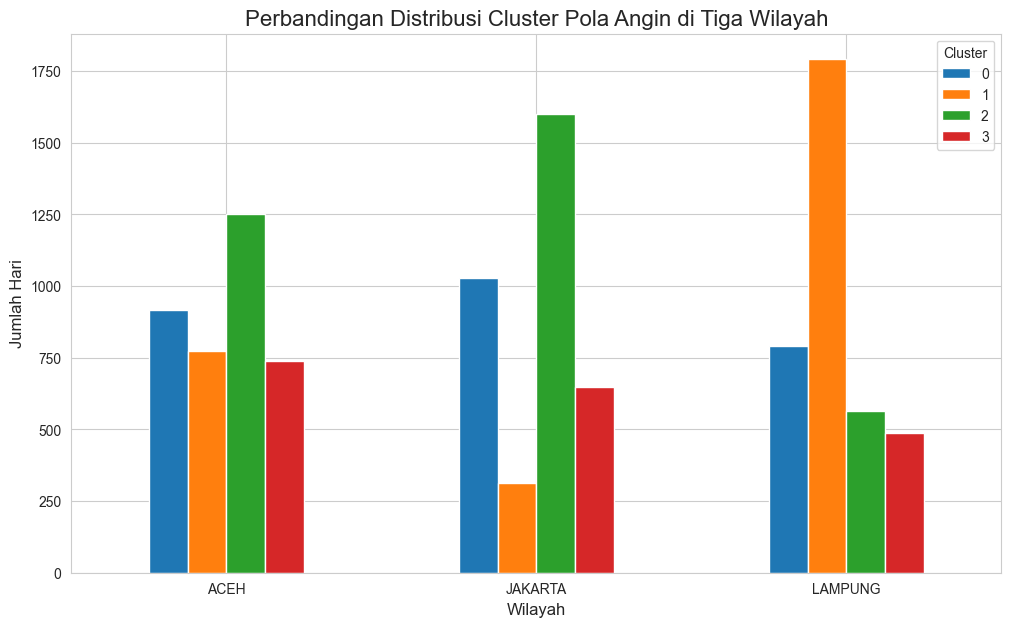

In [25]:
# Menghitung jumlah hari untuk setiap cluster di masing-masing wilayah
comparison_df = df_cleaned.groupby([KOLOM_WILAYAH, 'Cluster']).size().unstack(fill_value=0)

print("Distribusi Jumlah Hari per Cluster di Setiap Wilayah:")
print(comparison_df)

# Membuat visualisasi perbandingan
comparison_df.plot(kind='bar', stacked=False, figsize=(12, 7))
plt.title('Perbandingan Distribusi Cluster Pola Angin di Tiga Wilayah', fontsize=16)
plt.xlabel('Wilayah', fontsize=12)
plt.ylabel('Jumlah Hari', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Cluster')
plt.show()